In [461]:
import pandas as pd
import numpy as np
import seaborn as sns
import patsy
import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.linear_model import lars_path
%matplotlib inline

In [462]:
#Concating 18 Pages containing Book and Author Details into a data Frame


books_df = pd.concat(map(pd.read_csv, ['Children_page1_2_3.csv','Children_page4_5_6.csv','Children_page7_8_9.csv','Children_page10_11_12.csv','Children_page13_14_15.csv','Children_page16_17_18.csv']), ignore_index = True)
books_df.to_csv("Children_Book_Rating.csv")

# Read from Different CSV File


In [ ]:
#DATA CLEANING
# Data Cleaning Process, removing entries with Book rating and Author Average Rating Missing
#Making Dummy Variable to find if author was born in USA or outside
#books_df_eda[(books_df_eda["author_average_rating"] == 0.0)]   
#books_df_eda[books_df_eda["authot_no_rating"] == 0] CHECKING FOR RECORDS WIRH NO AUTHOR RATING    
#books_df_eda[books_df_eda["author_no_review"] == 0] CHECKING FOR RECORDS WIRH NO AUTHOR REVIEWS

#books_df_eda[books_df_eda["author_distinct_work"] == 0].count()  #0 entries   
#books_df_eda[books_df_eda["author_followers"] == 0].count()  #60 entries  -- should be ok as author not active on goodread
# Book Rating is normally distributed


In [413]:

books_df_eda = books_df.copy(deep = True)
#DROPPING TARGET VARIABLE FROM DATA FRAME
books_df_eda.drop(books_df_eda[(books_df_eda["book_rating"] == 0)].index, inplace = True) #121 rows
#DROPPING BOOK RELATED FEATURES WHICH ARE NOT AVAILABLE IN REAL TIME SCENARIO WHERE WE NEED TO PREDICT RATING OF
#UNPUBLISHED BOOKS
books_df_eda.drop(columns = ["no_rating","score","no_votes"], inplace = True)
#Managing Missing Entries
books_df_eda.drop(books_df_eda[books_df_eda["author_average_rating"] == 0].index, inplace = True)
#Making Born in US Category depending if author is born in US or Not
books_df_eda["Born in US"] = books_df_eda["author_country"].apply(lambda x: x in ["The United States", "in The United States", "New York", "NY",'Ohio'])
books_df_eda["Born in US"] = books_df_eda["Born in US"].astype(int)
#Taking Logarithm of Author Distinct Work to convert into a normal distribution
books_df_eda["log_distinct_work"] = np.log(books_df_eda["author_distinct_work"])


In [468]:
#Analyse features for type of distribution, outliers etc
books_df_eda.describe()

,book_rating,author_dob,author_average_rating,authot_no_rating,author_no_review,author_distinct_work,author_followers,Born in US,log_distinct_work
count,1508.000000,1508.000000,1508.000000,1.508000e+03,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000
mean,4.170935,1183.727454,4.139781,7.928127e+05,24564.077586,253.762599,8799.000000,0.520557,4.280553
std,0.238158,934.549094,0.209916,2.796224e+06,76146.170002,878.127052,43785.800352,0.499743,1.628714
min,3.320000,0.000000,3.460000,8.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000
25%,4.030000,0.000000,4.010000,7.387000e+03,699.750000,25.000000,43.000000,0.000000,3.218876
50%,4.170000,1899.000000,4.140000,7.819050e+04,3876.000000,77.000000,282.000000,1.000000,4.343805
75%,4.290000,1931.000000,4.240000,3.780198e+05,13377.500000,224.000000,1749.250000,1.000000,5.411646
max,4.970000,2015.000000,4.940000,2.998669e+07,670076.000000,20794.000000,375146.000000,1.000000,9.942420


Text(0.5, 1.0, 'Book Rating')

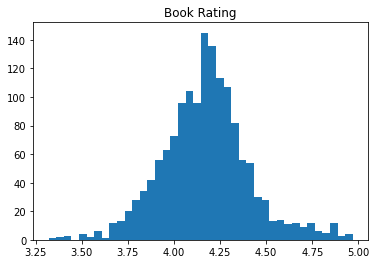

In [389]:
# Book Rating is normally distributed
import matplotlib.pyplot as plt
plt.hist(books_df_eda["book_rating"], bins = 40)
plt.title("Book Rating")  # Mean/Median = 4.170000  STD = .238

In [ ]:
#Author Average rating: Median: 4.1, Mean = 4.14, Standard Deviation: .21
#Book Rating Median: 4.17, Mean = 4.17, Standard Deviation = .24

Text(0.5, 1.0, 'Author Average Rating')

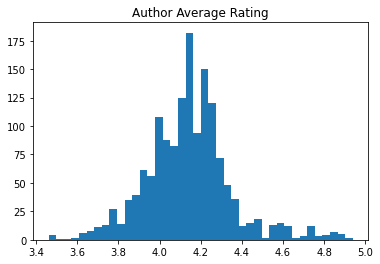

In [390]:
# Author Average Rating is normally distributed
plt.hist(books_df_eda["author_average_rating"], bins = 40)
plt.title("Author Average Rating")  # Mean/Median = 4.140000  STD = .21

Text(0.5, 1.0, 'Author Log Distinct Work')

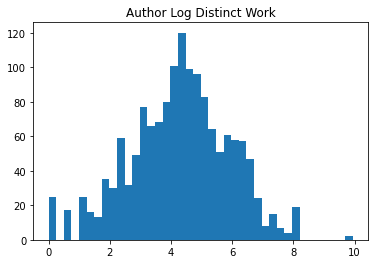

In [466]:
#Logarithm of Author Distinct Work is normally distributed
plt.hist(books_df_eda["log_distinct_work"], bins = 40)
plt.title("Author Log Distinct Work")

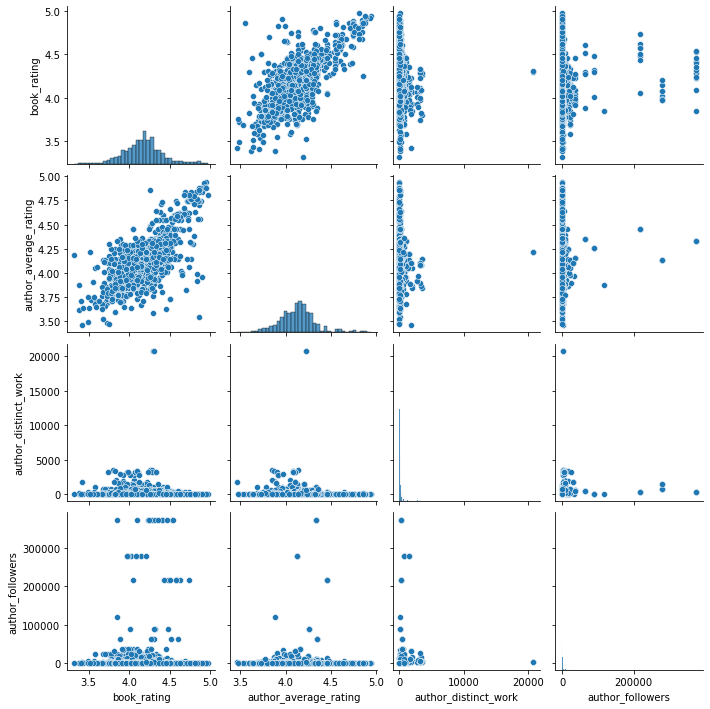

In [392]:
#Pair Plot for Target and Features
import seaborn as sns
sns.pairplot(books_df_eda,vars =["book_rating","author_average_rating","author_distinct_work","author_followers"])

#Corelation exist between Author No of Rating/Author No of Reviews/Author Followers
#Corelation exist between Book Rating and Author_Average_ratimg


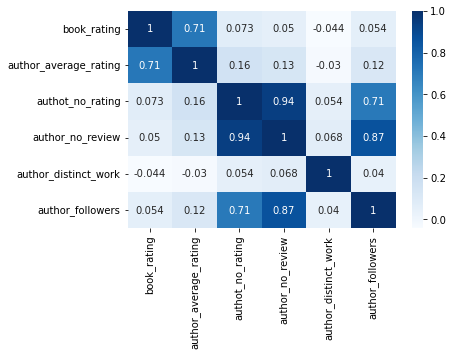

In [415]:
#Correlation Heat Map
temp = books_df_eda.copy(deep = True)
temp.drop(columns = ["book_name","author_name","author_country","author_dob","Born in US","log_distinct_work"], inplace = True)
sns.heatmap(temp.corr(), cmap="Blues",annot = True);


In [471]:
# Plotting Regression Plot/Residual Plot and Normal Q-Q Plot
# Code adopted from Metis Exercise Solution
def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))
    
    rgr = LinearRegression()
    rgr.fit(x,y)
    pred = rgr.predict(x)

    plt.subplot(1, 3, 1)
    plt.scatter(x,y)
    plt.plot(x, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

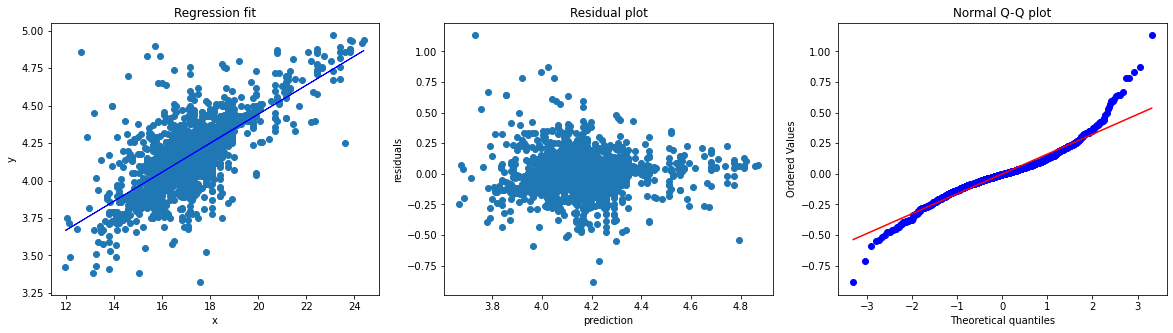

In [472]:
#Plotting Relation between Book Rating and Author Average Rating Squared
x = books_df_eda[['author_average_rating']] * books_df_eda[['author_average_rating']]
y = books_df_eda["book_rating"]  # predictor
diagnostic_plot(x, y)

In [473]:
#Simple regression model
#dividing data into train(64%), validate(16%) and test (20%)
#All Features plotted as feature with book rating as target
#Dummy Variable:
#1. Born in US: Binary
#2. Rating Squared
#3. Percentage presence of author in top 1800 records
#4. Interaction Variable by multiplying no of rating and no of reviews
#After observing performance on Validation data, train the data on (Training + Validation data set) and 
#reported scores as R2 and MAE
#Adjusted R2 on Training data = .545
#Adjusted R2 on Training + Validation Data = .539
#High Condition No: so multicollinearity between features
#Durbin-Watson: 2.03 between 1.5 to 2.5 Errors are not corelated, they are independent

/var/folders/gw/wvwjhy9x081fklj612jm2m100000gn/T/ipykernel_22737/2828459446.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['percent'] = x_train["author_name"].map(lambda x: 100* list1[x]/sum1)
/var/folders/gw/wvwjhy9x081fklj612jm2m100000gn/T/ipykernel_22737/2828459446.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['sq_rating'] = x_train['author_average_rating']*x_train['author_average_rating']
/var/folders/gw/wvwjhy9x081fklj612jm2m100000gn/T/ipykernel_22737/2828459446.py:20: Sett

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     129.1
Date:                Tue, 22 Feb 2022   Prob (F-statistic):          2.57e-158
Time:                        16:57:28   Log-Likelihood:                 417.23
No. Observations:                 964   AIC:                            -814.5
Df Residuals:                     954   BIC:                            -765.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5813      0.059     44.087      0.0

/Users/divyauppal/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/divyauppal/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


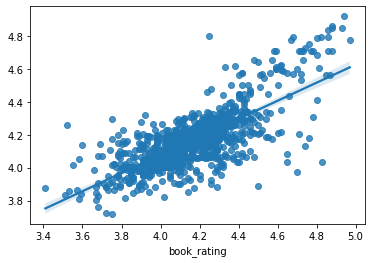

In [476]:
import seaborn as sns
import sklearn.datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV,ElasticNet
from sklearn.model_selection import (cross_val_score, train_test_split, 
                                     KFold, GridSearchCV)
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
selected_cols = ["author_dob","author_average_rating","authot_no_rating","author_no_review","author_followers","Born in US","author_name","log_distinct_work"]
X,x_test,Y,y_test = train_test_split(books_df_eda[selected_cols],books_df_eda[['book_rating']],test_size =.2,random_state =52)
x_train,x_val,y_train,y_val = train_test_split(X,Y,test_size =.2,random_state =42)

list1 = x_train['author_name'].value_counts()
sum1 = sum(list1)
x_train['percent'] = x_train["author_name"].map(lambda x: 100* list1[x]/sum1)


x_train['sq_rating'] = x_train['author_average_rating']*x_train['author_average_rating']
x_train["product_rating_review"] = x_train['authot_no_rating']*x_train['author_no_review']
x_train.drop(columns = ["author_name","author_average_rating"],inplace = True)
x_train = sm.add_constant(x_train)


list2 = x_val['author_name'].value_counts()
sum2 = sum(list2)
x_val['percent'] = x_val["author_name"].map(lambda x: 100* list2[x]/sum2)
x_val['sq_rating'] = x_val['author_average_rating']*x_val['author_average_rating']
x_val["product_rating_review"] = x_val['authot_no_rating']*x_val['author_no_review']
x_val.drop(columns = ["author_name","author_average_rating"],inplace = True)
x_val = sm.add_constant(x_val)

model_test = sm.OLS(y_train.values,x_train.values)
result_test = model_test.fit()
print(result_test.summary())

sns.regplot(y_train,result_test.predict(x_train))


list3 = X['author_name'].value_counts()
sum3 = sum(list3)
X['percent'] = X["author_name"].map(lambda x: 100* list3[x]/sum3)
X['sq_rating'] = X['author_average_rating']*X['author_average_rating']
X["product_rating_review"] = X['authot_no_rating']*X['author_no_review']
X.drop(columns = ["author_name","author_average_rating"],inplace = True)
X = sm.add_constant(X)

model_test = sm.OLS(Y.values,X.values)
result_test = model_test.fit()
print(result_test.summary())

list4 = x_test['author_name'].value_counts()
sum4 = sum(list4)
x_test['percent'] = x_test["author_name"].map(lambda x: 100* list4[x]/sum4)

x_test['sq_rating'] = x_test['author_average_rating']*x_test['author_average_rating']
x_test["product_rating_review"] = x_test['authot_no_rating']*x_test['author_no_review']
x_test.drop(columns = ["author_name","author_average_rating"],inplace = True)
x_test = sm.add_constant(x_test)

predict = result_test.predict(x_test)


In [ ]:
#Lasso regression model using cross validation (10 fold cross validation)
#10% data held for testing

In [478]:
selected_cols = ["author_dob","author_average_rating","authot_no_rating","author_no_review","author_followers","Born in US","author_name","log_distinct_work"]
x_train, x_holdout, y_train, y_holdout = train_test_split(books_df_eda[selected_cols], books_df_eda['book_rating'], test_size=0.1, random_state=52)


list1 = x_train['author_name'].value_counts()
sum1 = sum(list1)
x_train['percent'] = x_train["author_name"].map(lambda x: 100* list1[x]/sum1)
x_train['sq_rating'] = x_train['author_average_rating']*x_train['author_average_rating']
x_train["product_rating_review"] = x_train['authot_no_rating']*x_train['author_no_review']
x_train.drop(columns = ["author_name","author_average_rating"],inplace = True)

list2 = x_holdout['author_name'].value_counts()
sum2 = sum(list2)
x_holdout['percent'] = x_holdout["author_name"].map(lambda x: 100* list2[x]/sum2)
x_holdout['sq_rating'] = x_holdout['author_average_rating']*x_holdout['author_average_rating']
x_holdout["product_rating_review"] = x_holdout['authot_no_rating']*x_holdout['author_no_review']
x_holdout.drop(columns = ["author_name","author_average_rating"],inplace = True)

kfold = KFold(n_splits=10, shuffle=True, random_state=0)
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
std.fit(x_train)
x_tr = std.transform(x_train)
x_te = std.transform(x_holdout)

alpha = np.logspace(-4, -.1, 20)

lasso_model = LassoCV(alphas = alpha, cv=kfold)
lasso_model.fit(x_tr, y_train)

print(list(zip(x_train.columns,lasso_model.coef_)))
print(f" Lasso Model score for training data: {lasso_model.score(x_tr,y_train)}")

print(f" Lasso Model score for test data: {lasso_model.score(x_te,y_holdout)}")

[('author_dob', -0.011145760912730358), ('authot_no_rating', -0.04770150712235438), ('author_no_review', -0.0006219400555262747), ('author_followers', 0.0), ('Born in US', -0.0028877471460844297), ('log_distinct_work', -0.011633539851297517), ('percent', -0.005773465384779519), ('sq_rating', 0.16759052061344218), ('product_rating_review', 0.04602076264252951)]
 Lasso Model score for training data: 0.5415412660988271
 Lasso Model score for test data: 0.4416719748190857


In [480]:

print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(x_tr, y_train.values, method='lasso')

Computing regularization path using the LARS ...


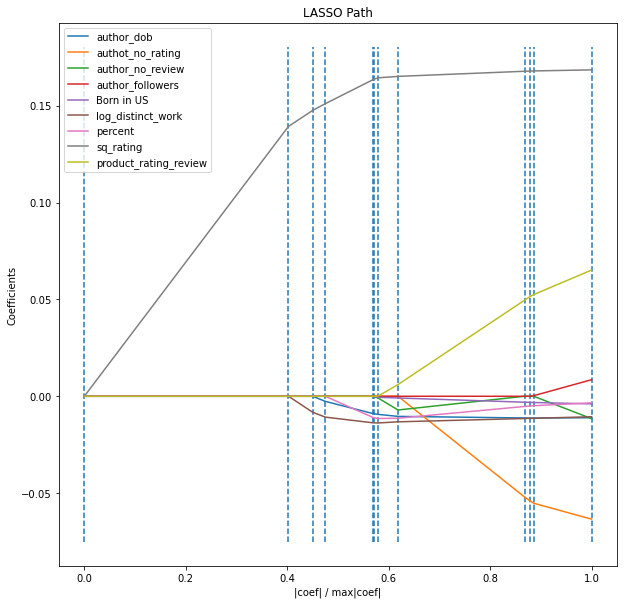

In [481]:
# plotting the LARS path  
#Code from Metis Answer Material
#Helping to find which features become significant at what level

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(x_train.columns)
plt.show()

In [482]:
#Calculating RMSE, MAE and R2 by using all feature variables
import numpy as np

rgr = LinearRegression()
rgr.fit(X,Y)
pred = rgr.predict(x_test)
residual = pred - y_test

rsme = np.sqrt(((residual) ** 2).mean())
mae = (np.absolute(residual)).mean()
print(f"RMSE is : {rsme}")
print(f"MAE is: {mae}")
print(f"R2 is {r2_score(y_test,pred)}")

RMSE is : book_rating    0.171454
dtype: float64
MAE is: book_rating    0.115616
dtype: float64
R2 is 0.4855147255589979


In [ ]:
#Simple regression model
#dividing data into train(64%), validate(16%) and test (20%)
#6 Features plotted as feature with book rating as target
#Dummy Variable:
#1. Rating Squared
#2. Percentage presence of author in top 1800 records
#3. Interaction Variable by multiplying no of rating and no of reviews
#After observing performance on Validation data, train the data on (Training + Validation data set) and 
#reported scores as R2 and MAE
#Adjusted R2 on Training data = .544
#Adjusted R2 on Training + Validation Data = .538
#High Condition No: so multicollinearity between features
#Durbin-Watson: 2.03 between 1.5 to 2.5 Errors are not corelated, they are independent

/var/folders/gw/wvwjhy9x081fklj612jm2m100000gn/T/ipykernel_22737/115242064.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['percent'] = x_train["author_name"].map(lambda x: 100* list1[x]/sum1)
/var/folders/gw/wvwjhy9x081fklj612jm2m100000gn/T/ipykernel_22737/115242064.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['sq_rating'] = x_train['author_average_rating']*x_train['author_average_rating']
/var/folders/gw/wvwjhy9x081fklj612jm2m100000gn/T/ipykernel_22737/115242064.py:20: Setting

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     192.5
Date:                Tue, 22 Feb 2022   Prob (F-statistic):          1.14e-160
Time:                        17:16:26   Log-Likelihood:                 414.83
No. Observations:                 964   AIC:                            -815.7
Df Residuals:                     957   BIC:                            -781.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5618      0.058     44.433      0.0

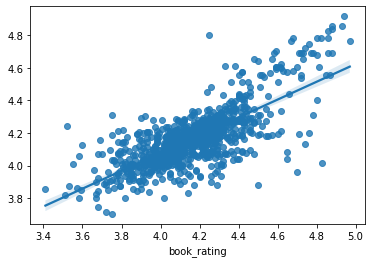

In [484]:
import seaborn as sns
import sklearn.datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV,ElasticNet
from sklearn.model_selection import (cross_val_score, train_test_split, 
                                     KFold, GridSearchCV)
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
selected_cols = ["author_average_rating","authot_no_rating","author_no_review","author_name","log_distinct_work"]
X,x_test,Y,y_test = train_test_split(books_df_eda[selected_cols],books_df_eda[['book_rating']],test_size =.2,random_state =52)
x_train,x_val,y_train,y_val = train_test_split(X,Y,test_size =.2,random_state =42)

list1 = x_train['author_name'].value_counts()
sum1 = sum(list1)
x_train['percent'] = x_train["author_name"].map(lambda x: 100* list1[x]/sum1)


x_train['sq_rating'] = x_train['author_average_rating']*x_train['author_average_rating']
x_train["product_rating_review"] = x_train['authot_no_rating']*x_train['author_no_review']
x_train.drop(columns = ["author_name","author_average_rating"],inplace = True)
x_train = sm.add_constant(x_train)


list2 = x_val['author_name'].value_counts()
sum2 = sum(list2)
x_val['percent'] = x_val["author_name"].map(lambda x: 100* list2[x]/sum2)
x_val['sq_rating'] = x_val['author_average_rating']*x_val['author_average_rating']
x_val["product_rating_review"] = x_val['authot_no_rating']*x_val['author_no_review']
x_val.drop(columns = ["author_name","author_average_rating"],inplace = True)
x_val = sm.add_constant(x_val)

model_test = sm.OLS(y_train.values,x_train.values)
result_test = model_test.fit()
print(result_test.summary())

sns.regplot(y_train,result_test.predict(x_train))


list3 = X['author_name'].value_counts()
sum3 = sum(list3)
X['percent'] = X["author_name"].map(lambda x: 100* list3[x]/sum3)
X['sq_rating'] = X['author_average_rating']*X['author_average_rating']
X["product_rating_review"] = X['authot_no_rating']*X['author_no_review']
X.drop(columns = ["author_name","author_average_rating"],inplace = True)
X = sm.add_constant(X)

model_test = sm.OLS(Y.values,X.values)
result_test = model_test.fit()
print(result_test.summary())

list4 = x_test['author_name'].value_counts()
sum4 = sum(list4)
x_test['percent'] = x_test["author_name"].map(lambda x: 100* list4[x]/sum4)

x_test['sq_rating'] = x_test['author_average_rating']*x_test['author_average_rating']
x_test["product_rating_review"] = x_test['authot_no_rating']*x_test['author_no_review']
x_test.drop(columns = ["author_name","author_average_rating"],inplace = True)
x_test = sm.add_constant(x_test)

predict = result_test.predict(x_test)


In [ ]:
#Model 2 with 6 features
#r2 on test data: .4876
#RMSE = .1711
#MAE = .1148

In [486]:
import numpy as np

rgr = LinearRegression()
rgr.fit(X,Y)
pred = rgr.predict(x_test)
residual = pred - y_test

rsme = np.sqrt(((residual) ** 2).mean())
mae = (np.absolute(residual)).mean()
print(f"RMSE is : {rsme}")
print(f"MAE is: {mae}")
print(f"R2 is {r2_score(y_test,pred)}")

RMSE is : book_rating    0.171102
dtype: float64
MAE is: book_rating    0.114817
dtype: float64
R2 is 0.4876229393397332


In [ ]:
#Final Simple regression model
#dividing data into train(64%), validate(16%) and test (20%)
#4 Features plotted as feature with book rating as target
# Variable:
#1. Rating Squared
#2. Interaction Variable by multiplying no of rating and no of reviews
#3. Author No of Rating
#4. Author NO of Reviews
#After observing performance on Validation data, train the data on (Training + Validation data set) and 
#reported scores as R2 and MAE
#Adjusted R2 on Training data = .539
#Adjusted R2 on Training + Validation Data = .534

#Durbin-Watson: 2.03 between 1.5 to 2.5 Errors are not corelated, they are independent

/var/folders/gw/wvwjhy9x081fklj612jm2m100000gn/T/ipykernel_22737/702740036.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['sq_rating'] = x_train['author_average_rating']*x_train['author_average_rating']
/var/folders/gw/wvwjhy9x081fklj612jm2m100000gn/T/ipykernel_22737/702740036.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train["product_rating_review"] = x_train['authot_no_rating']*x_train['author_no_review']
/Users/divyauppal/opt/anaconda3/lib/python3.9/site-packages/pandas/core/fram

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     282.8
Date:                Tue, 22 Feb 2022   Prob (F-statistic):          1.45e-160
Time:                        18:54:53   Log-Likelihood:                 408.87
No. Observations:                 964   AIC:                            -807.7
Df Residuals:                     959   BIC:                            -783.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5027      0.051     48.889      0.0

/Users/divyauppal/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


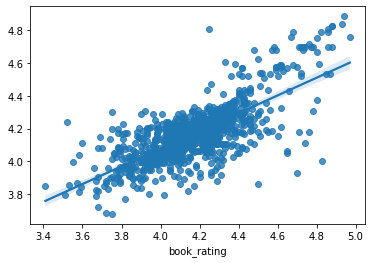

In [514]:
import seaborn as sns
import sklearn.datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV,ElasticNet
from sklearn.model_selection import (cross_val_score, train_test_split, 
                                     KFold, GridSearchCV)
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
selected_cols = ["author_average_rating","author_name","authot_no_rating","author_no_review"]
X,x_test,Y,y_test = train_test_split(books_df_eda[selected_cols],books_df_eda[['book_rating']],test_size =.2,random_state =52)
x_train,x_val,y_train,y_val = train_test_split(X,Y,test_size =.2,random_state =42)


x_train['sq_rating'] = x_train['author_average_rating']*x_train['author_average_rating']
x_train["product_rating_review"] = x_train['authot_no_rating']*x_train['author_no_review']
x_train.drop(columns = ["author_name","author_average_rating"],inplace = True)
x_train = sm.add_constant(x_train)




x_val['sq_rating'] = x_val['author_average_rating']*x_val['author_average_rating']
x_val["product_rating_review"] = x_val['authot_no_rating']*x_val['author_no_review']
x_val.drop(columns = ["author_name","author_average_rating"],inplace = True)
x_val = sm.add_constant(x_val)

model_test = sm.OLS(y_train.values,x_train.values)
result_test = model_test.fit()
print(result_test.summary())

sns.regplot(y_train,result_test.predict(x_train))
predict = result_test.predict(x_train)

x_test['sq_rating'] = x_test['author_average_rating']*x_test['author_average_rating']
x_test["product_rating_review"] = x_test['authot_no_rating']*x_test['author_no_review']
x_test.drop(columns = ["author_name","author_average_rating"],inplace = True)
x_test = sm.add_constant(x_test)

                 
    
X['sq_rating'] = X['author_average_rating']*X['author_average_rating']
X["product_rating_review"] = X['authot_no_rating']*X['author_no_review']
X.drop(columns = ["author_name","author_average_rating"],inplace = True)
X = sm.add_constant(X)

model_test = sm.OLS(Y.values,X.values)
result_test = model_test.fit()
print(result_test.summary())




In [511]:
#Model 3 with 4 features
#r2 on test data: .4914
#RMSE = .1704
#MAE = .1130
x_train.head()

,const,authot_no_rating,author_no_review,sq_rating,product_rating_review
756,1.0,36739,1306,15.2881,47981134
1482,1.0,664,145,13.6900,96280
635,1.0,14716,1289,17.2225,18968924
1632,1.0,17093,3830,17.7241,65466190
1154,1.0,458716,18816,17.8084,8631200256


RSME is : book_rating    0.170747
dtype: float64
MAE is: book_rating    0.114592
dtype: float64
R2 is 0.48974800658454953


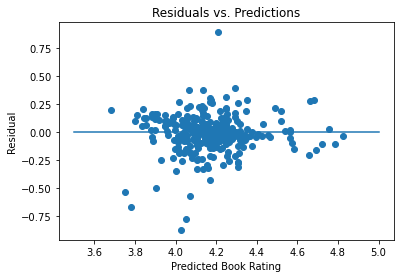

In [513]:


rgr = LinearRegression()
rgr.fit(X,Y)
pred = rgr.predict(x_test)
residual = pred - y_test

#RESIDUAL PLOT IS RANDOM
plt.scatter(pred, residual)
plt.xlabel("Predicted Book Rating")
plt.ylabel("Residual")
plt.plot([3.5,5], [0, 0])
plt.title("Residuals vs. Predictions") 

rsme = np.sqrt(((residual) ** 2).mean())
mae = (np.absolute(residual)).mean()
print(f"RSME is : {rsme}")
print(f"MAE is: {mae}")
print(f"R2 is {r2_score(y_test,pred)}")

In [453]:
#COMPARING PREDICTED AND ACTUAL TARGET VALUES
Example = x_test.copy(deep = True)
y_test["Predicted Value"] = pred
print(x_test)
print(y_test)

      const  authot_no_rating  author_no_review  sq_rating  \
50      1.0            556616             37639    18.4900   
1625    1.0              1344               565    17.1396   
1142    1.0             20271              1416    16.3216   
1492    1.0          10310268            402766    18.7489   
1266    1.0            881114             37679    15.4449   
...     ...               ...               ...        ...   
565     1.0              3656               664    15.3664   
1003    1.0            127371             12350    16.4836   
700     1.0            398420             17321    15.3664   
65      1.0             91481              1745    17.2225   
368     1.0            240360             10888    16.1604   

      product_rating_review  
50              20950469624  
1625                 759360  
1142               28703736  
1492          4152625401288  
1266            33199494406  
...                     ...  
565                 2427584  
1003           

(array([ 1.,  1.,  0.,  1.,  0.,  2.,  1.,  2.,  1.,  5.,  7., 16., 23.,
        46., 67., 58., 30., 18., 11.,  7.,  0.,  3.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  1.]),
 array([-0.86374241, -0.80493291, -0.7461234 , -0.6873139 , -0.6285044 ,
        -0.56969489, -0.51088539, -0.45207588, -0.39326638, -0.33445688,
        -0.27564737, -0.21683787, -0.15802837, -0.09921886, -0.04040936,
         0.01840015,  0.07720965,  0.13601915,  0.19482866,  0.25363816,
         0.31244767,  0.37125717,  0.43006667,  0.48887618,  0.54768568,
         0.60649518,  0.66530469,  0.72411419,  0.7829237 ,  0.8417332 ,
         0.9005427 ]),
 <BarContainer object of 30 artists>)

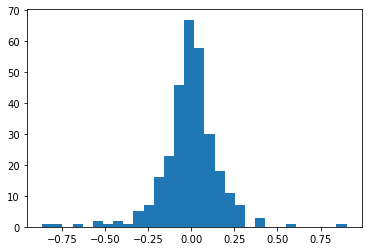

In [454]:
# PLOTTING RESIDUALS AS A HISTOGRAM
plt.hist(residual,bins = 30)

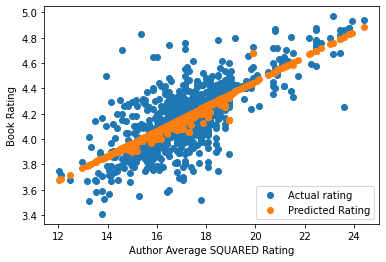

In [489]:
#PLOTTING PREDICTED AND ACTUAL BOOK RATING V/S AUTHOR AVERAGE SQUARED RATING 
plt.scatter(x_train.sq_rating,y_train, label = "Actual rating")
plt.scatter(x_train.sq_rating,predict, label = "Predicted Rating")
plt.xlabel("Author Average SQUARED Rating")
plt.ylabel("Book Rating")
plt.legend()

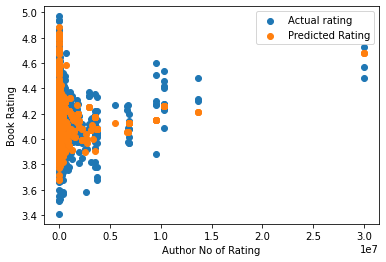

In [490]:
#PLOTTING PREDICTED AND ACTUAL BOOK RATING V/S AUTHOR NO OF RATING 
plt.scatter(x_train["authot_no_rating"],y_train,label = "Actual rating")
plt.scatter(x_train["authot_no_rating"],predict,label = "Predicted Rating");
plt.xlabel("Author No of Rating")
plt.ylabel("Book Rating")
plt.legend()

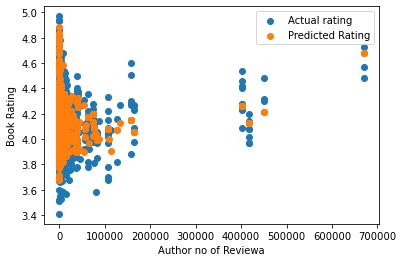

In [491]:
#PLOTTING PREDICTED AND ACTUAL BOOK RATING V/S AUTHOR NO OF REVIEWS 
plt.scatter(x_train["author_no_review"],y_train,label = "Actual rating")
plt.scatter(x_train["author_no_review"],predict,label = "Predicted Rating");
plt.xlabel("Author no of Reviewa")
plt.ylabel("Book Rating")
plt.legend()

In [ ]:
#LASSO MODEL RUN ON FINAL MODEL USING CROSS VALIDATION WITH 10 SPLITS

[0.59141163 0.66610486 0.53783798 0.49543435 0.51386135 0.50076072
 0.53058636 0.38715567 0.47594438 0.46884759]
Linear Reg Mean Score:  0.5167944891976808


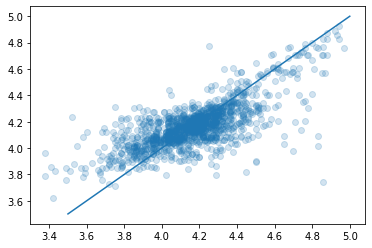

In [492]:
selected_cols = ["author_average_rating","author_name","log_distinct_work"]
x_train, x_holdout, y_train, y_holdout = train_test_split(books_df_eda[selected_cols], books_df_eda['book_rating'], test_size=0.1, random_state=52)

lin_reg_est = LinearRegression()
x_train['sq_rating'] = x_train['author_average_rating']* x_train['author_average_rating']
x_train.drop(columns = ["author_name","author_average_rating"],inplace = True)

x_holdout['sq_rating'] = x_holdout['author_average_rating']* x_holdout['author_average_rating']
x_holdout.drop(columns = ["author_name","author_average_rating"],inplace = True)

kfold = KFold(n_splits=10, shuffle=True, random_state=0)

scores = cross_val_score(lin_reg_est, x_train, y_train, cv=kfold)
print(scores)
print("Linear Reg Mean Score: ", np.mean(scores))

# Build the Model
lin_reg_est.fit(x_train, y_train)
                                                                                                    
y_train_pred = lin_reg_est.predict(x_train)
plt.scatter(y_train, y_train_pred, alpha=0.2)
plt.plot([3.5, 5], [3.5, 5])

In [ ]:
#PLOTTING PREDICTED AND ACTUAL TARGET VALUES FOR TEST DATA

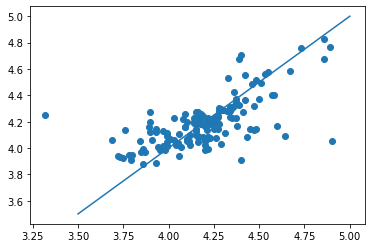

In [323]:
y_test_pred = lin_reg_est.predict(x_holdout)

plt.scatter(y_holdout, y_test_pred)
plt.plot([3.5, 5], [3.5, 5])

In [ ]:
#PLOTTING RESIDUAL VS PREDICTION FOR TEST DATA

Text(0.5, 1.0, 'Residuals vs. Predictions')

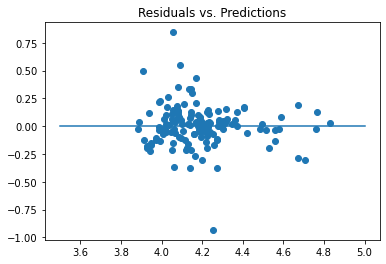

In [435]:
lin_reg_residuals = y_holdout - y_test_pred

plt.scatter(y_test_pred, lin_reg_residuals)
plt.plot([3.5,5], [0, 0])
plt.title("Residuals vs. Predictions") 

In [494]:
print(f"R2 Score for test data: {r2_score(y_holdout,y_test_pred)}")


R2 Score for test data: 0.4453662926353654


In [495]:
#TRYING INTRODUCING A DIFFERENT FEATURED NAMED LOG DISTINCT WORK TO SHOW IF ANY IMPROVEMENTS IN R1
#DID CROSS VALIDATION WITH 10 SPLITS
#r2 score is not impressive so model is rejected

selected_cols = ["author_average_rating","author_name","log_distinct_work"]
x_train, x_holdout, y_train, y_holdout = train_test_split(books_df_eda[selected_cols], books_df_eda['book_rating'], test_size=0.1, random_state=52)


x_train['sq_rating'] = x_train['author_average_rating']*x_train['author_average_rating']
x_train.drop(columns = ["author_name","author_average_rating"],inplace = True)

x_holdout['sq_rating'] = x_holdout['author_average_rating']*x_holdout['author_average_rating']
x_holdout.drop(columns = ["author_name","author_average_rating"],inplace = True)
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
std.fit(x_train)
x_tr = std.transform(x_train)
x_te = std.transform(x_holdout)

alpha = np.logspace(-4, -.1, 20)

lasso_model = LassoCV(alphas = alpha, cv=kfold)
lasso_model.fit(x_tr, y_train)

print(list(zip(x_train.columns,lasso_model.coef_)))
print(f" Lasso Model score for training data: {lasso_model.score(x_tr,y_train)}")

print(f" Lasso Model score for test data: {lasso_model.score(x_te,y_holdout)}")

[('log_distinct_work', -0.026772357334183417), ('sq_rating', 0.1661056187309211)]
 Lasso Model score for training data: 0.5282133688331894
 Lasso Model score for test data: 0.4455099860317405


In [ ]:
#code adapted from Metis coursework

In [ ]:
#Plotted graphs to find alpha for Lasso, Ridge and Elastic Net Models

Lasso Model:


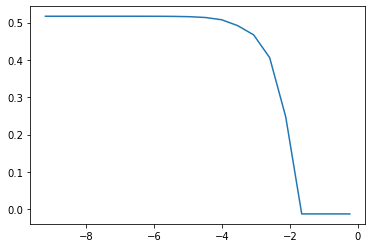

In [498]:
print("Lasso Model:")
params = {
    "alpha": np.logspace(-4, -.1, 20)
}

grid_est = GridSearchCV(Lasso(), param_grid=params, cv=kfold, 
                        return_train_score=False)
grid_est.fit(x_tr, y_train)
df = pd.DataFrame(grid_est.cv_results_)

df["alpha"] = df.params.apply(lambda val: val["alpha"])
plt.plot(np.log(df.alpha), df.mean_test_score);

In [499]:
grid_est.best_score_

0.5168197091638016

In [500]:
def build_grid_search_est(model, X, y, cv=5, **params):

    grid_est = GridSearchCV(model, param_grid=params, cv=kfold, 
                            return_train_score=False)
    grid_est.fit(X, y)
    df = pd.DataFrame(grid_est.cv_results_)
    for param in params:
        df[param] = df.params.apply(lambda val: val[param])
#       plt.plot(np.log(df.alpha), df.mean_test_score);
        plt.semilogx(df.alpha, df.mean_test_score)
    return grid_est

Lasso Grid Search


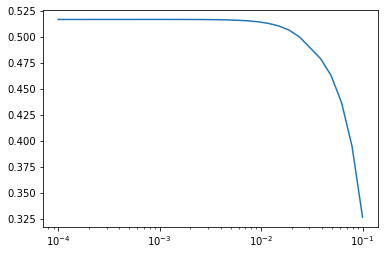

In [201]:
print("Lasso Grid Search")
lasso_grid_est = build_grid_search_est(Lasso(), x_tr, y_train, cv=kfold,
                                       alpha=np.logspace(-4, -1, 30))

Ridge Grid Search


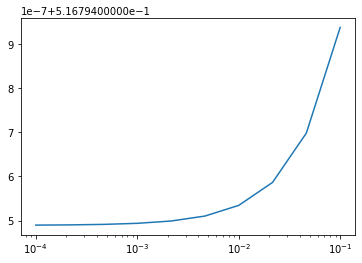

In [501]:
print("Ridge Grid Search")
ridge_grid_est = build_grid_search_est(Ridge(), x_tr, y_train, cv=kfold,
                                       alpha=np.logspace(-4, -1, 10))

Elastic Net Grid Search


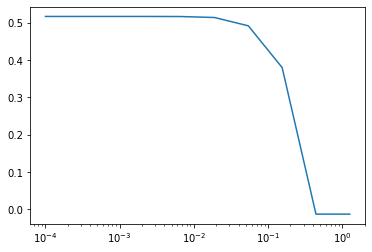

In [502]:
print("Elastic Net Grid Search")
elastic_net_grid_est = build_grid_search_est(ElasticNet(), x_tr, y_train, cv=kfold,
                                             alpha=np.logspace(-4, 0.1, 10))

In [503]:
#Predicted r2 with all 4 regression models; using extra feature as log distinct_author_work
#no improvement in r2
# so model with 4 features and r2 of .4914 is kept
from sklearn.metrics import r2_score, mean_squared_error

y_pred1 = lin_reg_est.predict(x_holdout)
print("Linear Regression:", r2_score(y_holdout, y_pred1))

y_pred2 = lasso_grid_est.predict(x_te)
print("Lasso Regression:", r2_score(y_holdout, y_pred2))

y_pred3 = ridge_grid_est.predict(x_te)
print("Ridge Regression:", r2_score(y_holdout, y_pred3))

y_pred4 = elastic_net_grid_est.predict(x_te)
print("ElasticNet Regression:", r2_score(y_holdout, y_pred4))

Linear Regression: 0.4453662926353654
Lasso Regression: 0.446576111142892
Ridge Regression: 0.44537116225728246
ElasticNet Regression: 0.44707139791705797


array([[<AxesSubplot:title={'center':'author_dob'}>]], dtype=object)

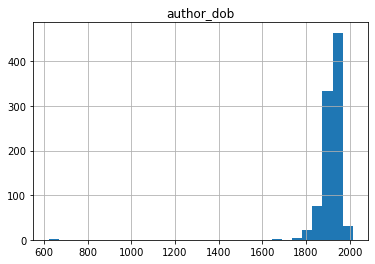

In [505]:
#Extra: Not related to coursework
# Many authors took profession of being an author for children book between years 1900-1960 
x_dob = books_df_eda[(books_df_eda["author_dob"]!= 0)]

x_dob.hist(column = "author_dob", bins =30)


In [507]:
#Code adapted from Metis coursework
#Joint Plot between predicted and actual target variable

/Users/divyauppal/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


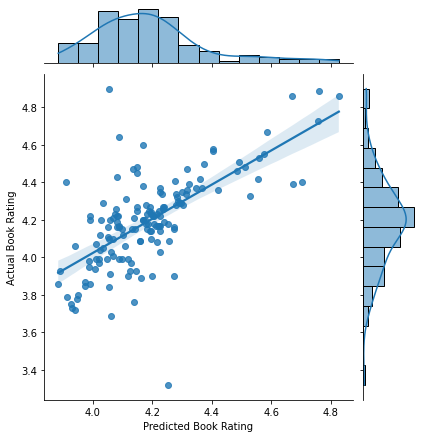

In [506]:
a = sns.jointplot(y_pred2, y_holdout, kind='reg')
a.set_axis_labels('Predicted Book Rating', 'Actual Book Rating')


In [509]:
#Code adapted from Metis coursework
#Joint Plot between predicted and residual

/Users/divyauppal/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


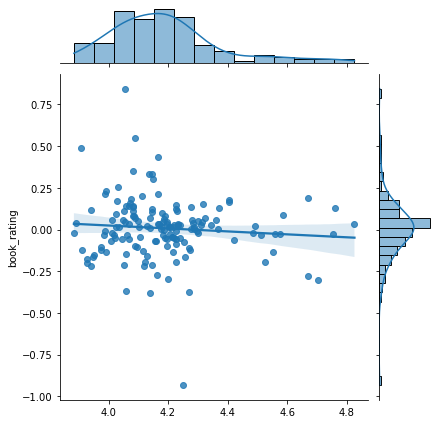

In [508]:
b = sns.jointplot(y_pred2, y_holdout - y_pred2, kind='reg')
a.set_axis_labels('Predicted Book Rating', 'Residual')

In [297]:
#Code adapted from Metis coursework
#Tried Random Forest Regression and Gradient Bossting regression and checked r2
#r2 is still not impressive and kept the simple regression model with r2 of .4914
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

rf = RandomForestRegressor(n_estimators=2000, max_features=2, max_depth=2)
rf.fit(x_tr, y_train)
y_pred = rf.predict(x_te)
print("Random Forest Regression:", r2_score(y_holdout, y_pred))

gbm = GradientBoostingRegressor(n_estimators=500, max_depth=2, learning_rate=.01)
gbm.fit(x_tr, y_train)
y_pred = gbm.predict(x_te)
print("Gradient Boosted Regression:", r2_score(y_holdout, y_pred))

Random Forest Regression: 0.4354589325197201
Gradient Boosted Regression: 0.44888531228060435
